### Validating the satellite data obtained in the CSV format



In [1]:
# Import prerequisites

import  numpy as np
import  matplotlib.pyplot as plt
import  h5py
import  csv
from    datetime import datetime

import  lunarsky
from    lunarsky.time   import Time

from astropy.time import Time as myT
print(f'''lunarsky path: {lunarsky.__path__[0]}''')


lunarsky path: /home/maxim/.virtualenvs/lusee-simpy/lib/python3.10/site-packages/lunarsky


In [2]:
import  lusee
from    lusee import Observation, Satellite, ObservedSatellite
print(f'''lusee path: {lusee.__path__[0]}''')

lusee path: /home/maxim/projects/lusee/luseepy/lusee


In [6]:
csv_file, csv_reader = None, None
line_count = 0

parse_time_string = '%d %b %Y %H:%M:%S.%f'


inputfile   = '/home/maxim/sat.csv'
csv_file    = open(inputfile, "r")
csv_reader  = csv.reader(csv_file, delimiter=',')

# -- INSPECT THE DATA AND REPORT
for row in csv_reader:
    if line_count == 0:
        print(f'{len(row)} columns detected. Column names are:')
        print('---------------------------------------')
        i = 0
        for col in row:
            print(f'{i:2} {col}')
            i+=1
        print('---------------------------------------')
        line_count += 1
    else:
        if (len(row) == 0): break
        if line_count == 1: start_time = row[0]
        current_time = row[0]
        line_count += 1

print(f'Processed {line_count} CSV lines total (including the header).')
t_start =   Time(datetime.strptime(start_time,   parse_time_string))
t_end   =   Time(datetime.strptime(current_time, parse_time_string))
print(f'Time range of the data (string format ** MJD): "{start_time} ** {t_start.mjd}" to "{current_time} ** {t_end.mjd}"')

csv_file.close()

24 columns detected. Column names are:
---------------------------------------
 0 Time (UTCG)
 1 EarthJ2000-x (km)
 2 EarthJ2000-y (km)
 3 EarthJ2000-z (km)
 4 EarthJ2000-Vx (km/sec)
 5 EarthJ2000-Vy (km/sec)
 6 EarthJ2000-Vz (km/sec)
 7 J2000-qx
 8 J2000-qy
 9 J2000-qz
10 J2000-qs
11 Geodetic Altitude (km)
12 SunEarth Angle (deg)
13 SunMoon Angle (deg)
14 EarthMoon Angle (deg)
15 EarthBdyX (km)
16 EarthBdyY (km)
17 EarthBdyZ (km)
18 MoonBdyX (km)
19 MoonBdyY (km)
20 MoonBdyZ (km)
21 SunBdyX (km)
22 SunBdyY (km)
23 SunBdyZ (km)
---------------------------------------
Processed 86003 CSV lines total (including the header).
Time range of the data (string format ** MJD): "2 Dec 2025 08:04:33.000 ** 61011.336493055554" to "31 Jan 2026 01:25:02.000 ** 61071.05905092593"


In [19]:
line_count  = 0

N           = 3000

buffer      = []
header      = ''

index_list = [0, 18, 19, 20]


inputfile   = '/home/maxim/sat.csv'
csv_file    = open(inputfile, "r")
csv_reader  = csv.reader(csv_file, delimiter=',')

# -- PROCESS
for row in csv_reader:
    if line_count == 0:
        line_count += 1
        if len(index_list)>0:
            row = [row[i] for i in index_list]
        header = ','.join(row) # preserve, to add to the metadata in HDF5; then skip to the data
        print(header)
        continue

    if line_count>N: break

    if (len(row) == 0): break # protect against the trailing empty string(s)
    my_time =  Time(datetime.strptime(row[0], '%d %b %Y %H:%M:%S.%f'))
    row[0] = my_time.mjd
    row = [float(row[i]) for i in index_list]
    buffer.append(row) # print(row)
    line_count += 1


    # print(row)1

result = np.array(buffer, dtype=np.float64)

T = result[:, 0]
X = result[:, 1]
Y = result[:, 2]
Z = result[:, 3]

Time (UTCG),MoonBdyX (km),MoonBdyY (km),MoonBdyZ (km)


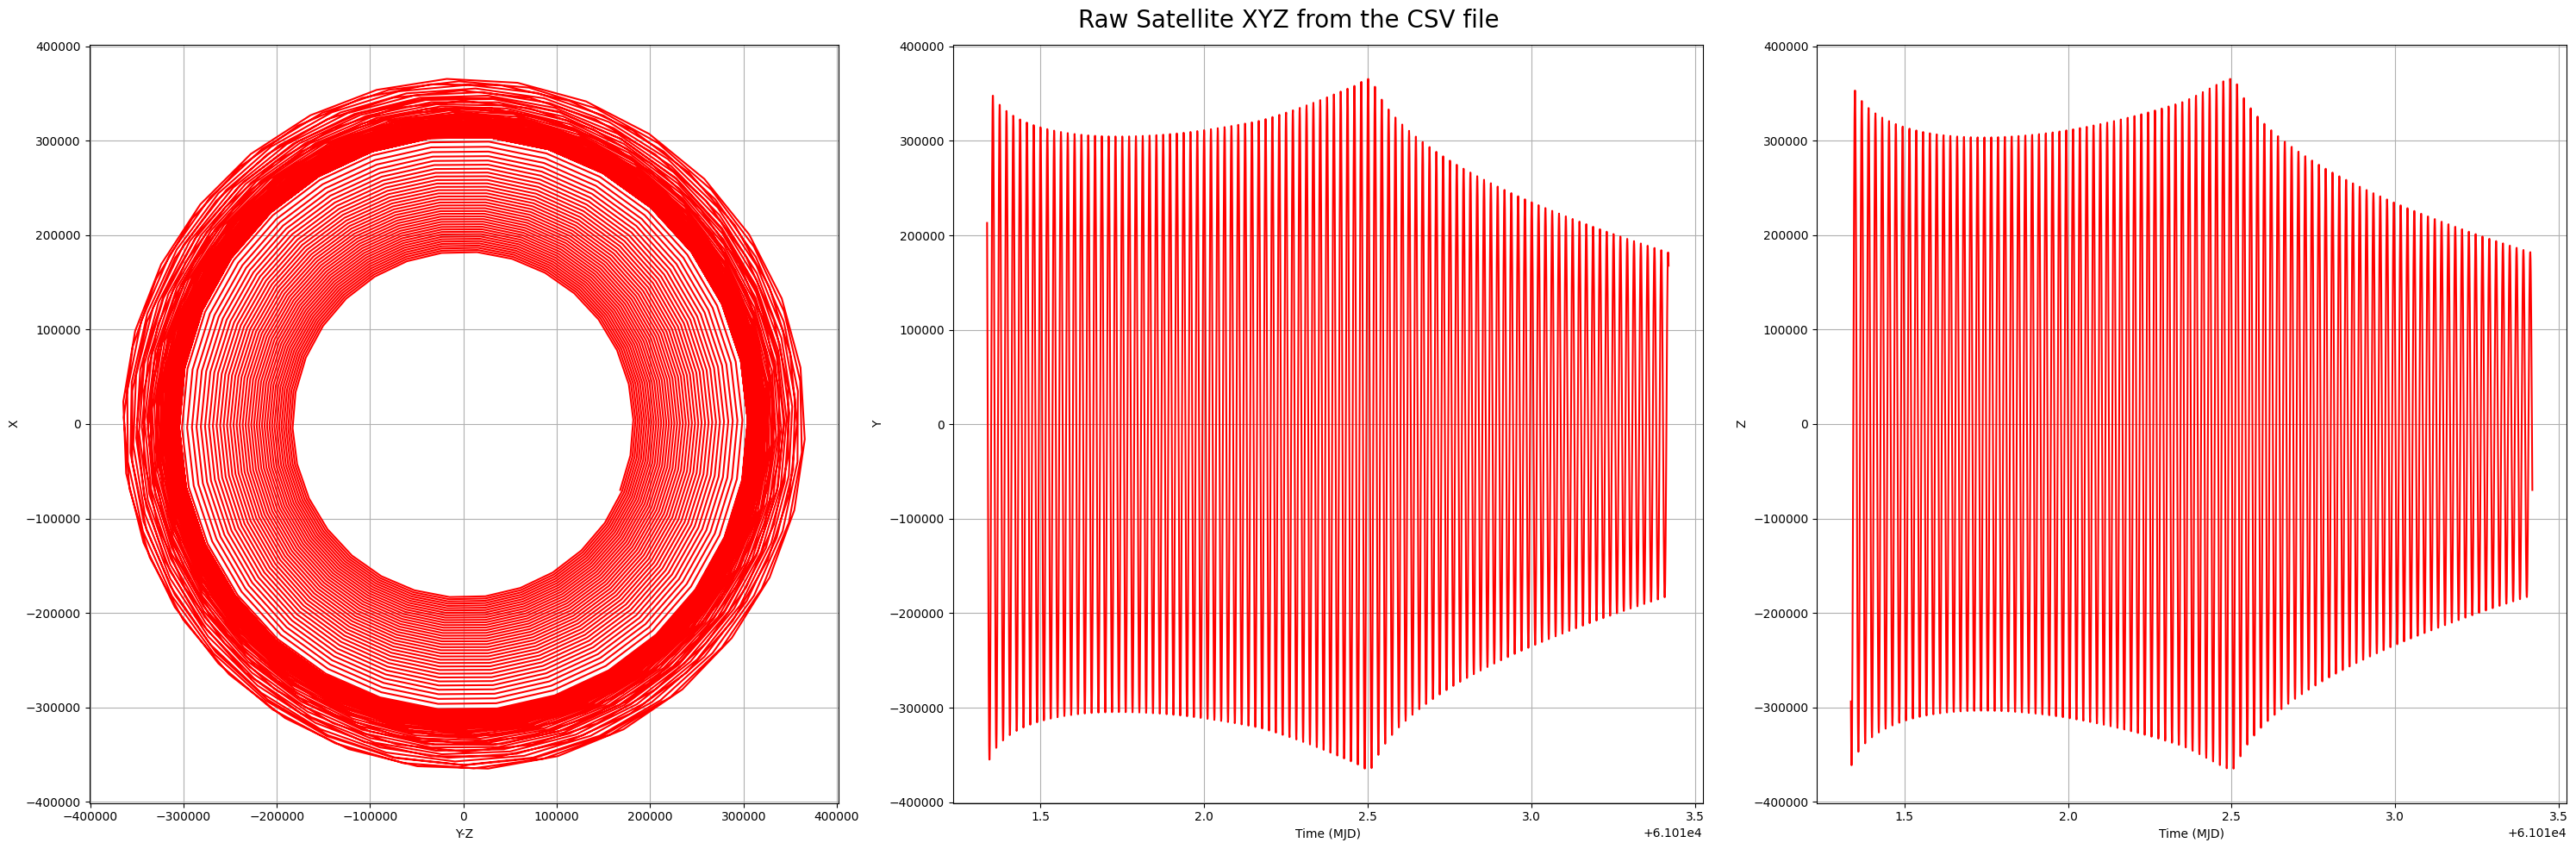

In [28]:
fig, (p1, p2, p3) = plt.subplots(1,3)
fig.suptitle('Raw Satellite XYZ from the CSV file', fontsize=20)
plt.rcParams["figure.figsize"] = [30., 10.]
plt.rcParams["figure.autolayout"] = True

p1.grid(True)
p2.grid(True)
p3.grid(True)

p1.set_xlabel('Y-Z')
p1.set_ylabel('X')

p2.set_xlabel('Time (MJD)')
p2.set_ylabel('Y')

p3.set_xlabel('Time (MJD)')
p3.set_ylabel('Z')

_ = p1.plot(Y, Z,  color="red")
_ = p2.plot(T, Y,  color="red")
_ = p3.plot(T, Z,  color="red")

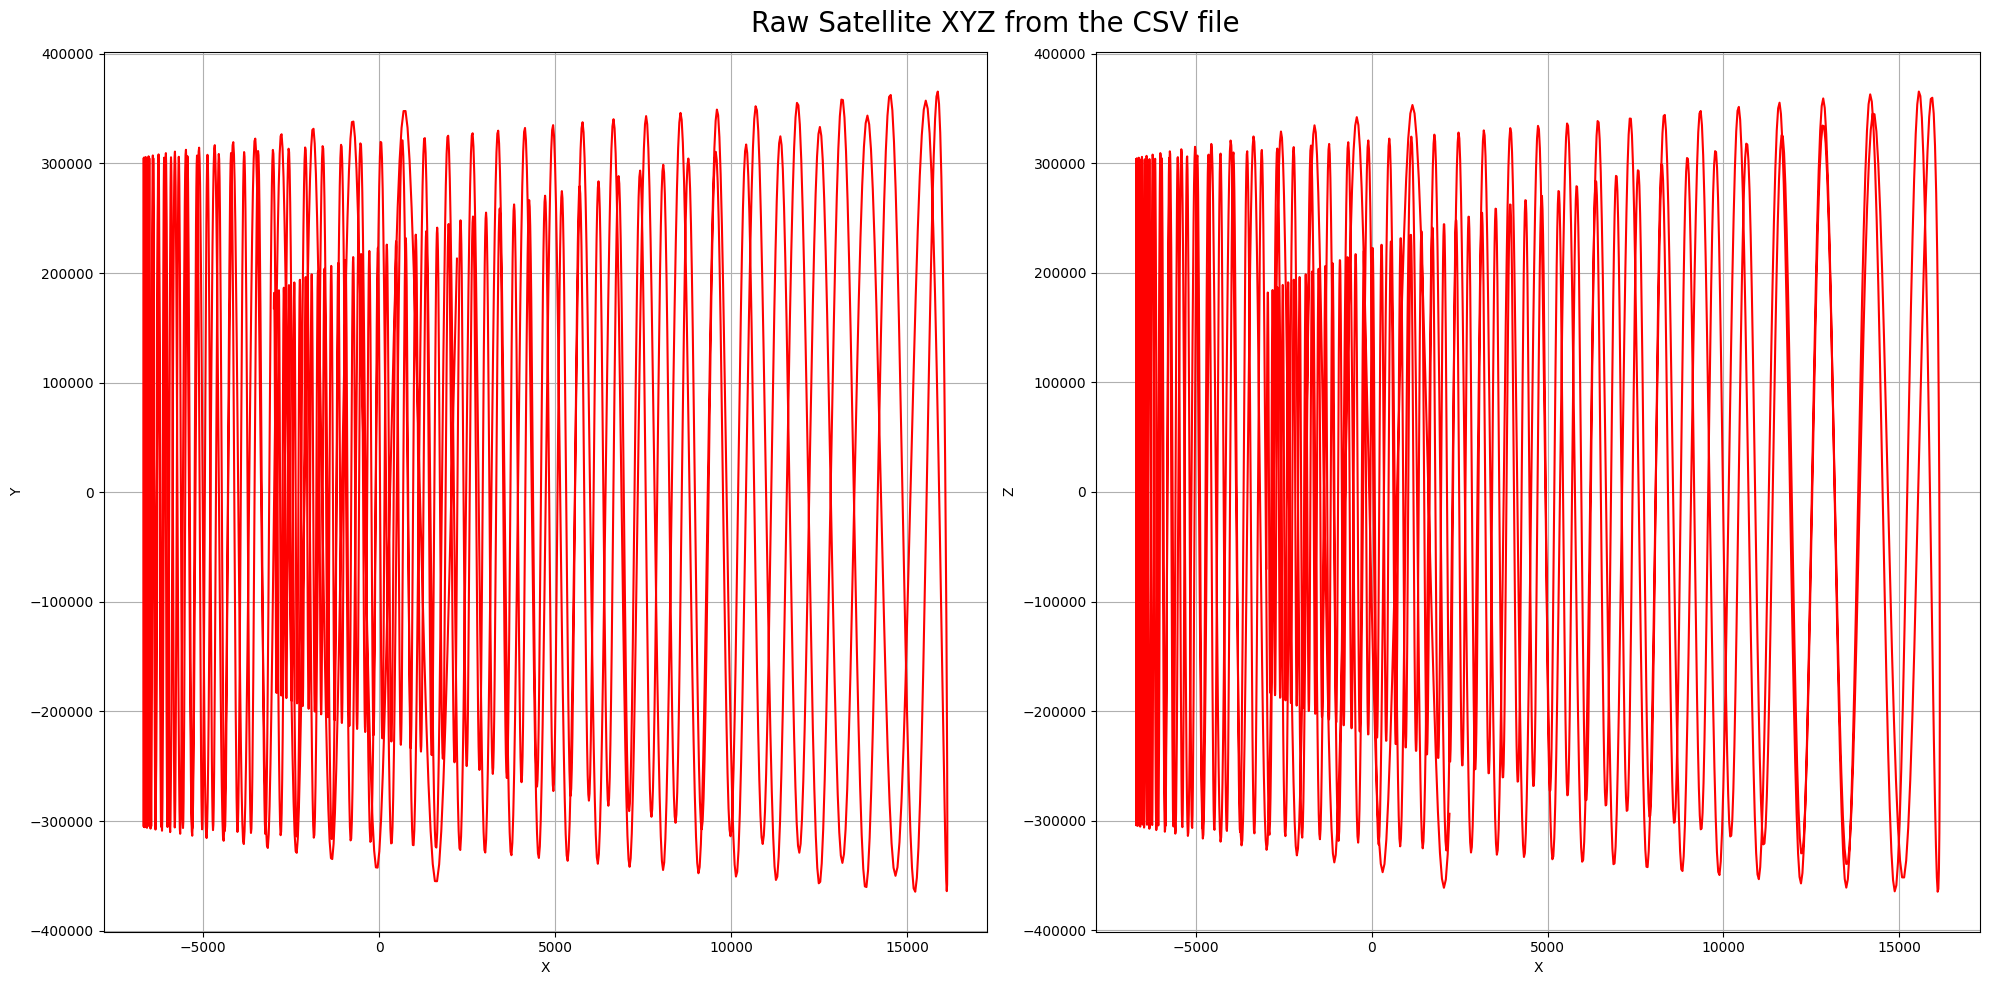

In [31]:
fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Raw Satellite XYZ from the CSV file', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 10.]
plt.rcParams["figure.autolayout"] = True

p1.grid(True)
p2.grid(True)

p1.set_xlabel('X')
p1.set_ylabel('Y')

p2.set_xlabel('X')
p2.set_ylabel('Z')

_ = p1.plot(X, Y,  color="red")
_ = p2.plot(X, Z,  color="red")


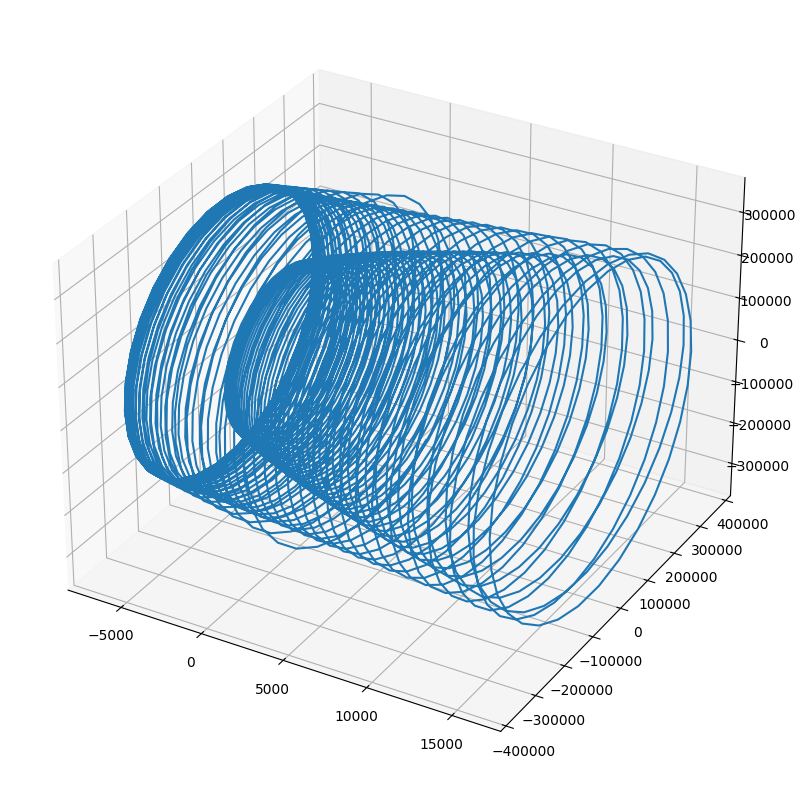

In [20]:
a = plt.figure().add_subplot(projection='3d')
a.plot(X, Y, Z)

plt.show()



In [3]:
# Optional: if you need to read prefab data on the satellite orbit, do it here for testing

sat_file    = h5py.File('/home/maxim/foo.hdf5')
ds_data     = sat_file["/data/trajectory"]
sat_data    = np.array(ds_data[:]) # data array
times       = sat_data[:, 0]
traj        = sat_data[:, [1,2,3]]

print(times.shape)
print(traj.shape)

N = times.shape[0]

myArray = np.empty(N, dtype=myT)

for i in range(N):
    myArray[i] = Time(times[i], format='mjd')


(86002,)
(86002, 3)


In [4]:

obs     = Observation(time_range=myArray)


In [5]:
# Basic test of the updated ObservedSatellite object

# Two options to define the interval - tuple of strings or a more complex string:
use_tuple = True
if use_tuple:
    interval    = ("2025-02-10 00:00:00", "2025-03-07 23:45:00")
else:
    interval    = "2025-02-10 00:00:00 to 2025-03-07 23:45:00"

# see cell above
# interval = times

# obs     = Observation(time_range=interval, deltaT_sec=15*60)
S       = traj # Satellite()
obsat   = ObservedSatellite(obs, S)



a numpy array
[<Time object: scale='utc' format='mjd' value=61011.336493055554>
 <Time object: scale='utc' format='mjd' value=61011.33718501157>
 <Time object: scale='utc' format='mjd' value=61011.33787945602> ...
 <Time object: scale='utc' format='mjd' value=61071.058018344906>
 <Time object: scale='utc' format='mjd' value=61071.05871278935>
 <Time object: scale='utc' format='mjd' value=61071.05905092593>]


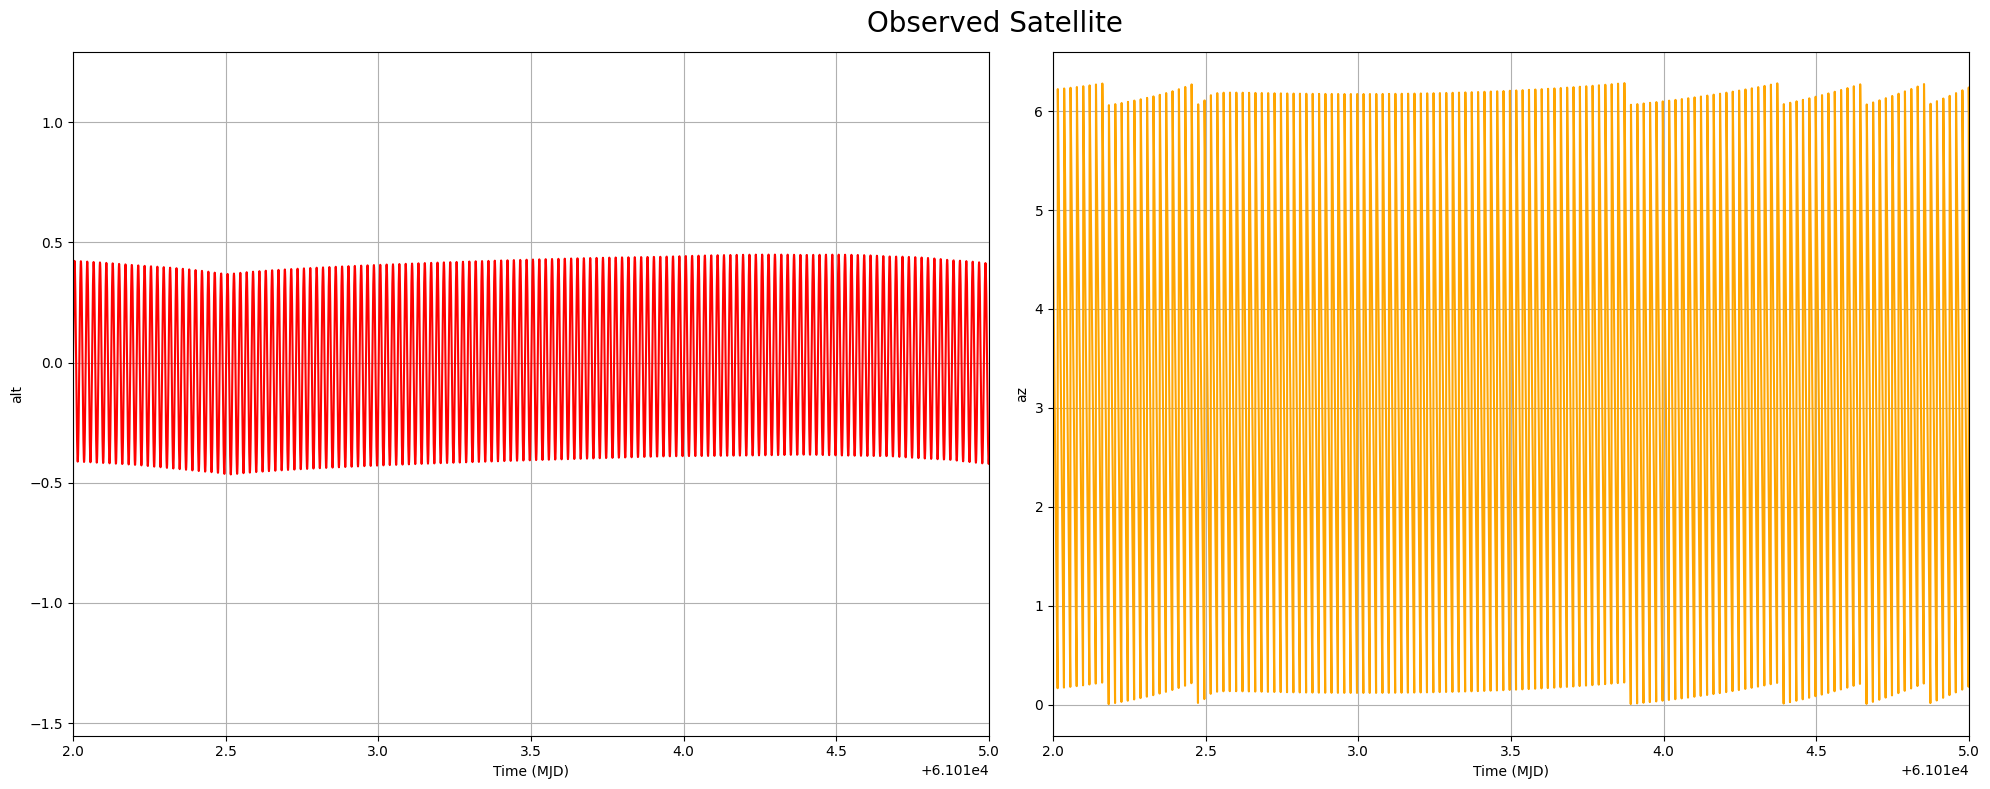

In [11]:

fig, (p1, p2) = plt.subplots(1,2)
fig.suptitle('Observed Satellite', fontsize=20)
plt.rcParams["figure.figsize"] = [20., 8.]
plt.rcParams["figure.autolayout"] = True


#p1=plt.subplot()
p1.grid(True)
p2.grid(True)

#p1.set_xlim([60715,60730])
#p2.set_xlim([60715,60730])

p1.set_xlim([61012,61015])
p2.set_xlim([61012,61015])

p1.set_xlabel('Time (MJD)')
p1.set_ylabel('alt')

p2.set_xlabel('Time (MJD)')
p2.set_ylabel('az')

_ = p1.plot(obsat.mjd, obsat.alt,  color="red", label="Satellite")
_ = p2.plot(obsat.mjd, obsat.az,   color="orange", label="Satellite")

---

### Plot the trajectory

Test plot with canonical settings, for back reference.


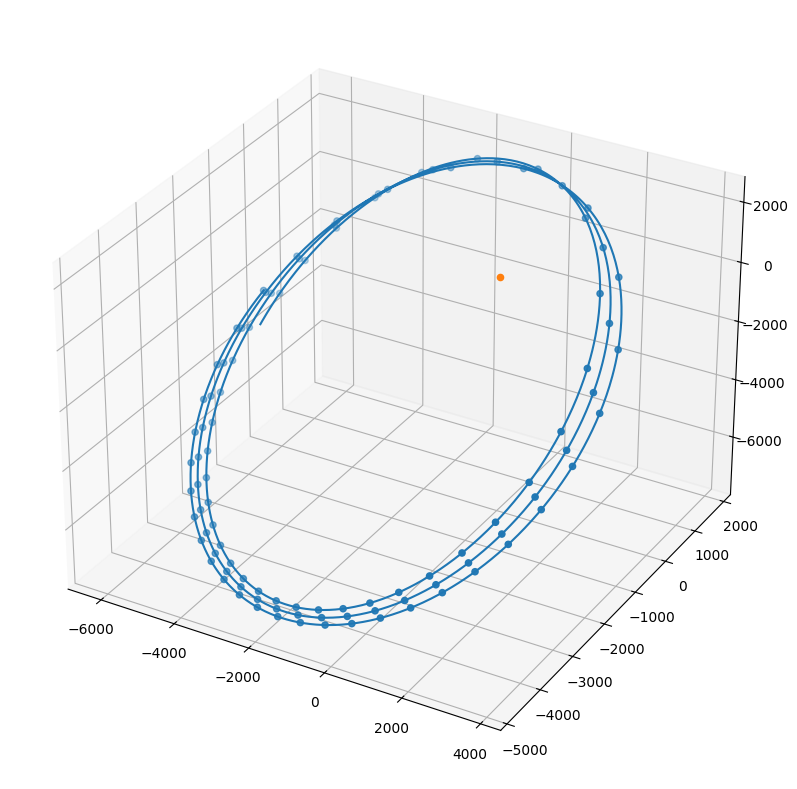

In [6]:
obs     = Observation(deltaT_sec=60)
S       = Satellite()
obsat   = ObservedSatellite(obs, S)

# fig, (p1, p2) = plt.subplots(1,2)
fig = plt.figure(figsize=plt.figaspect(0.5))
#fig.suptitle('Simulation', fontsize=20)
plt.rcParams["figure.figsize"] = [12., 6.]
#plt.rcParams["figure.autolayout"] = True


ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot3D(obsat.posxyz[:2000,0], obsat.posxyz[:2000,1], obsat.posxyz[:2000,2])
ax.scatter3D(obsat.posxyz[:2000:20,0], obsat.posxyz[:2000:20,1], obsat.posxyz[:2000:20,2])
_ = ax.scatter3D(0,0,0)

In [1]:
# ---- just keep for later
# fig     = plt.figure(figsize=(20,10))
# plt.rcParams["figure.autolayout"] = True
# ax      = plt.axes(projection='3d')
# posxyz  = obsat.posxyz

# ax.plot3D(posxyz[:2000,0],posxyz[:2000,1],posxyz[:2000,2])
# ax.scatter3D(posxyz[:2000:20,0],posxyz[:2000:20,1],posxyz[:2000:20,2])
# _ = ax.scatter3D(0,0,0)

# ax = fig.add_subplot(1, 2, 2)
# obsat.plot_tracks(ax)
# plt.show()


Text(0, 0.5, 'N-S')

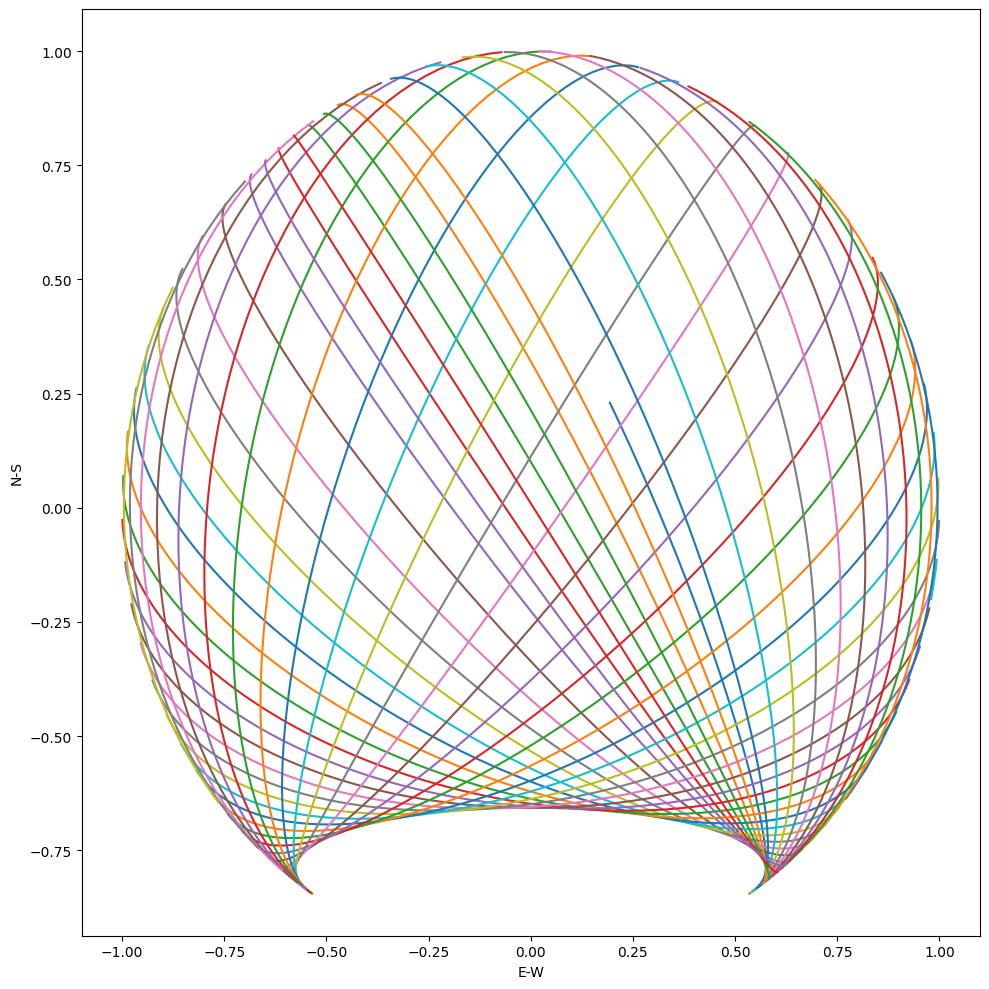

In [7]:
plt.figure(figsize=(10,10))
obsat.plot_tracks(plt)
plt.xlabel("E-W")
plt.ylabel("N-S")

In [24]:
transits = obsat.get_transit_indices()
print (len(transits))

55


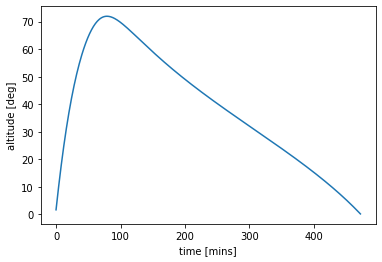

In [7]:
# Take transit #5
i,j = transits[5]
plt.plot(np.arange(j-i),obsat.alt_rad()[i:j]/np.pi*180)
plt.xlabel('time [mins]')
plt.ylabel('altitude [deg]')
pass